In [100]:
import numpy as np
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import statsmodels.formula.api as sm
import winsound
import timeit
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import datetime
%load_ext cython

#Variables
defK = 35
defELO = 1200

detsX = pd.read_csv("../input/RegularSeasonDetailedResults.csv")
compX = pd.read_csv("../input/RegularSeasonCompactResults.csv")
tournX = pd.read_csv("../input/TourneyDetailedResults.csv")
compY = pd.read_csv("../input/TourneyCompactResults.csv")
seeds = pd.read_csv("../input/TourneySeeds.csv")
sample = pd.read_csv("../input/sample_submission.csv")

tournX['isTourn']=tournX.apply(lambda row: 1, axis = 1)
detsX['isTourn']=detsX.apply(lambda row: 0, axis = 1)
detsX = detsX.append(tournX)

#Set up ELO basis
detsX['WELO'] = detsX.apply(lambda row: defELO, axis=1)
detsX['LELO'] = detsX.apply(lambda row: defELO, axis=1)

#Engineer Features
detsX['Ptdiff'] = detsX.apply(lambda row: row['Wscore']-row['Lscore'], axis=1)

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [197]:
from mpl_toolkits.mplot3d import Axes3D

In [83]:
#Create ELO Scores
##Create initial ELOs for all teams (1200)
#ELOs = pd.concat(compY[['Wteam','Lteam']][compY['Season'] == 2016],compY[['Lteam','Wteam']][compY['Season'] == 2016])
ELOs = compX[['Wteam','Lteam']].append(compX[['Lteam','Wteam']][compX['Season'] == 2016])
ELOs['ELO'] = ELOs.apply(lambda row: defELO, axis=1)
ELOs = ELOs.drop('Lteam', 1)
ELOs['team'] = ELOs['Wteam']
ELOs = ELOs.drop('Wteam', 1)
ELOs = ELOs[['team','ELO']]
ELOs=ELOs.groupby('team').mean()
ELOs['K']=ELOs.apply(lambda row: defK, axis = 1)
ELOs['Sgame']=ELOs.apply(lambda row: 0, axis = 1)
##Account for team churn year-to-year

In [113]:
%%cython
cpdef ELOCalc(double WR_old, double LR_old, int ptDiffPct, double WK=60, double LK=60, str court='N', int width=400):
    cdef double K
    cdef double probW
    cdef double probELO
    
    #Account for home court advantage
    if court == 'H':
        probCourt = 0.655
    elif court == 'A':
        probCourt = 1-0.655
    else:
        probCourt = 0.5
    #Calc prob winner wins
    #probELO = WR_old/(WR_old+LR_old)
    probELO = 1/(1+10**((LR_old-WR_old)/width))
    #Formula from http://www.mathpages.com/home/kmath267.htm
    probW = (probCourt*probELO)/(probCourt*probELO+(1-probCourt)*(1-probELO))
    #Set K based on W/L K and margin of victory
    K = (WK+LK)/2
    K=7/8*K+1/8*K*ptDiffPct**(1/8)
    WR_new = WR_old + K*(1-probW)
    LR_new = LR_old + K*(0-(1-probW))
    #ELOs.loc[Wteam, 'ELO'] = WR_new
    #ELOs.loc[Lteam, 'ELO'] = LR_new
    return [WR_new, LR_new]

In [114]:
#Probability that the team that won was going to win entering the game
def winProb(x):
    court = x['Wloc']
    ##Court Probablity added based on investigations below
    if court == 'H':
        probCourt = 0.655
    elif court == 'A':
        probCourt = 1-0.655
    else:
        probCourt = 0.5
    #Calc prob winner wins
    #probELO = x['WELO']/(x['WELO']+x['LELO'])
    probELO = 1/(1+10**((x['LELO']-x['WELO'])/400))
    probW = (probCourt*probELO)/(probCourt*probELO+(1-probCourt)*(1-probELO))
    return probW

In [115]:
def locReverse(loc):
    if loc == 'A':
        return 'H'
    elif loc == 'H':
        return 'A'
    else:
        return 'N'

In [116]:
for KValue in range(1,100,5):
    print(KValue)

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


In [117]:
kLoop = pd.DataFrame(columns={'Score1','Score2','K'})

In [127]:
dd={}

##Simulate ELO
##Setup data to ELO
#Time it
start = time.time()

#detsX = detsX.sort_index()
for KValue in range(1,152,5):
    ELOs['ELO'] = ELOs.apply(lambda row: defELO, axis=1)
    for year in range(2003,2017):
        games = detsX[detsX['Season']==year]
        dayArray = games['Daynum'].unique()
        #print(year)
        for day in dayArray:
            for a in games[['Wteam','Lteam','Wloc', 'Wscore', 'Lscore']][(games['Daynum'] == day)].as_matrix():
                #Set Historical ELO
                winPct = (a[3]-a[4])/a[3]
                firstELOs = [ELOs.loc[a[0]].ELO, ELOs.loc[a[1]].ELO]
                detsX.loc[(detsX.Season == year) & (detsX.Daynum == day) & (detsX.Wteam == a[0]),['WELO','LELO']] = (firstELOs)
                #detsX.loc[(year,day,a[0]),['WELO','LELO']] = (firstELOs)
                #Update Ongoing ELO
                ELOUpdate = ELOCalc(firstELOs[0], firstELOs[1], winPct, court=a[2], WK=KValue, LK=KValue)
                ELOs.loc[a[0], 'ELO'] = ELOUpdate[0]
                ELOs.loc[a[1], 'ELO'] = ELOUpdate[1]


    duration = time.time() - start
    winsound.Beep(2500,500)


    print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

    #Add ELODiff Metric
    detsX['ELODiff'] = detsX.apply(lambda row: row['WELO'] - row['LELO'] , axis=1)

    #creating a dataframe of relevant years
    useGames = detsX[(detsX['Season']>=2000)]

    ##Create ELO-based dataframe. This will be useful in creating an ML model with consisten team positions
    (useGames['Hteam'],useGames['Hscore'],useGames['Hloc'],useGames['Hfgm'],useGames['Hfga'],
     useGames['Hfgm3'],useGames['Hfga3'],useGames['Hfta'],useGames['Hor'],useGames['Hdr'],
     useGames['Hast'],useGames['Hto'],useGames['Hstl'],useGames['Hblk'],useGames['Hpf'],
     useGames['Loteam'],useGames['Loscore'],useGames['Loloc'],useGames['Lofgm'],useGames['Lofga'],
     useGames['Lofgm3'],useGames['Lofga3'],useGames['Lofta'],useGames['Loor'],useGames['Lodr'],
     useGames['Loast'],useGames['Loto'],useGames['Lostl'],useGames['Loblk'],useGames['Lopf'],
     useGames['HELO'],useGames['LoELO'], useGames['PtHDiff'], useGames['Hwon']
    ) = zip(*useGames.apply(lambda row: 
                           (row['Wteam'],row['Wscore'],row['Wloc'],row['Wfgm'],row['Wfga'],
                            row['Wfgm3'],row['Wfga3'],row['Wfta'],row['Wor'],row['Wdr'],
                            row['Wast'],row['Wto'],row['Wstl'],row['Wblk'],row['Wpf'],
                            row['Lteam'],row['Lscore'],locReverse(row['Wloc']),row['Lfgm'],row['Lfga'],
                            row['Lfgm3'],row['Lfga3'],row['Lfta'],row['Lor'],row['Ldr'],
                            row['Last'],row['Lto'],row['Lstl'],row['Lblk'],row['Lpf'],
                            row['WELO'], row['LELO'], row['Ptdiff'], 1)
                           if row['WELO'] > row['LELO'] else 
                           (row['Lteam'],row['Lscore'],locReverse(row['Wloc']),row['Lfgm'],row['Lfga'],
                            row['Lfgm3'],row['Lfga3'],row['Lfta'],row['Lor'],row['Ldr'],
                            row['Last'],row['Lto'],row['Lstl'],row['Lblk'],row['Lpf'],
                            row['Wteam'],row['Wscore'],row['Wloc'],row['Wfgm'],row['Wfga'],
                            row['Wfgm3'],row['Wfga3'],row['Wfta'],row['Wor'],row['Wdr'],
                            row['Wast'],row['Wto'],row['Wstl'],row['Wblk'],row['Wpf'],
                            row['LELO'],row['WELO'], -row['Ptdiff'], 0),
                           axis=1))

    useGames.reset_index(inplace=True)

    #Generate expected win % on all past games
    #useGames.loc[:,'Hprob'] = useGames.apply(lambda row: row['HELO']/(row['HELO']+row['LoELO']),axis=1)
    #useGames.loc[:,'Hprob'] = useGames.apply(winProb,axis=1)
    useGames.loc[:,'Hprob'] = useGames.apply(lambda row:
                                             1/(1+10**((row['LoELO']-row['HELO'])/400))
                                             ,axis=1)
    
    testLocal = useGames[(useGames['isTourn']==1)& (useGames['Season']>=2013)]
    Score1 = metrics.log_loss(testLocal['Hwon'], testLocal['Hprob'])
    Score2 = metrics.log_loss(useGames['Hwon'], useGames['Hprob'])
    kLoop=kLoop.append(pd.DataFrame(data={'Score1': [Score1],'Score2': Score2,'K': KValue}))
    print(KValue)
    print(Score1)
    print(Score2)
    dd[KValue]=useGames

5 Minute(s), 30 Second(s).
1
0.650515719852
0.671144064507
11 Minute(s), 39 Second(s).
6
0.585696648373
0.623793455594
17 Minute(s), 40 Second(s).
11
0.565884264068
0.603697164297
23 Minute(s), 44 Second(s).
16
0.556575978662
0.591881912993
29 Minute(s), 47 Second(s).
21
0.552209164494
0.584171369283
35 Minute(s), 53 Second(s).
26
0.55052497012
0.578902280545
42 Minute(s), 17 Second(s).
31
0.550381522846
0.575243706155
48 Minute(s), 19 Second(s).
36
0.551158091714
0.572722885498
54 Minute(s), 20 Second(s).
41
0.552501664985
0.571046234622
60 Minute(s), 22 Second(s).
46
0.554203716446
0.570019538363
66 Minute(s), 25 Second(s).
51
0.556136740238
0.569508057081
72 Minute(s), 27 Second(s).
56
0.558220232758
0.56941479759
78 Minute(s), 29 Second(s).
61
0.560401824861
0.569667854991
84 Minute(s), 42 Second(s).
66
0.562646492312
0.570212630621
90 Minute(s), 43 Second(s).
71
0.564930213856
0.571006833125
96 Minute(s), 45 Second(s).
76
0.567236150463
0.572017148754
102 Minute(s), 45 Second(s).


In [128]:
kLoop.to_csv('../output/KLOOP3.csv')

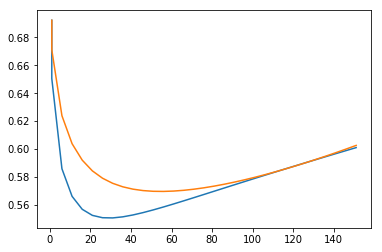

In [135]:
plt.plot(kLoop['K'],kLoop[['Score1','Score2']])
plt.show()

In [172]:
kLoop[kLoop['Score2']==min(kLoop['Score2'])]

,K,Score1,Score2
0,56.0,0.55822,0.569415


In [182]:
useGames['Hwon']=useGames.apply(lambda row: int(row['Hwon']),axis=1)

In [95]:
kLoop.to_csv('../output/KLOOP3.csv')

In [145]:
dfPanel = pd.Panel(dd)

In [155]:
widthLoop = pd.DataFrame(columns={'Score1','Score2','Width'})

In [ ]:
dd[56]

In [149]:
dfPanel.to_pickle('../input/kLoopPanel1')

In [ ]:
widthLoop = pd.DataFrame(columns={'Score1','Score2','Width','K'})

In [222]:
for currK in dd:
    for width in range (400,601,20):
        useGames = dfPanel[currK]
        useGames['HWprob'] = useGames.apply(lambda row:
                                                  1/(1+10**((row['LoELO']-row['HELO'])/width))
                                                  ,axis=1)
        useGames['Hwon']=useGames.apply(lambda row: int(row['Hwon']),axis=1)
        testLocal = useGames[(useGames['isTourn']==1)& (useGames['Season']>=2013)]
        Score1 = metrics.log_loss(testLocal['Hwon'], testLocal['HWprob'])
        Score2 = metrics.log_loss(useGames['Hwon'], useGames['HWprob'])
        widthLoop=widthLoop.append(pd.DataFrame(data={'Score1': [Score1],'Score2': Score2,'Width': width,'K': currK}))
    print(currK)

1
66
131
6
71
136
11
76
141
16
81
146
21
86
151
26
91
31
96
36
101
41
106
46
111
51
116
56
121
61
126


In [194]:
widthLoop=widthLoop.sort_values(['K','Width'])

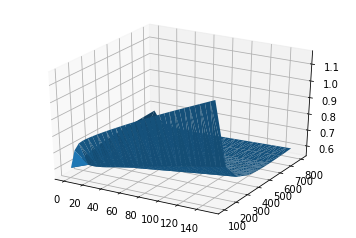

In [223]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(widthLoop['K'],widthLoop['Width'],widthLoop['Score1'])
plt.show()

In [224]:
widthLoop[(widthLoop['Score2']==min(widthLoop[widthLoop['K']==56]['Score2']))]

,K,Score1,Score2,Width
0,56.0,0.55939,0.566781,480.0


In [225]:
widthLoop[(widthLoop['Score2']==min(widthLoop['Score2']))]

,K,Score1,Score2,Width
0,76.0,0.566984,0.565283,520.0
